## **Laboratorio 6**
- Joaquín Campos - 22155
- Sofía García - 22210
- Julio García Salas - 22076

## **Inciso 1 y 2**

In [3]:
# Pasos 1–2 (con detección de codificación y JSON doble)
# - Lee traficogt.txt y tioberny.txt (UTF-16 / UTF-8, etc.)
# - Parseo robusto: JSON array, JSONL, JSON doblemente codificado, o texto plano
# - Normaliza a DataFrame con campos clave para siguientes pasos

from pathlib import Path
import json
import pandas as pd
import re
from typing import List, Dict, Any, Optional, Tuple

# -------------------- Localización de archivos --------------------
def resolve_paths() -> List[Path]:
    local = [Path("traficogt.txt"), Path("tioberny.txt")]
    mnt = [Path("/mnt/data/traficogt.txt"), Path("/mnt/data/tioberny.txt")]
    out = []
    for pl, pm in zip(local, mnt):
        out.append(pl if pl.exists() else (pm if pm.exists() else pl))
    return out

DATA_PATHS = resolve_paths()
OUT_PARQUET = Path("tweets_raw.parquet")
OUT_SAMPLE_CSV = Path("tweets_raw_sample.csv")

# -------------------- Utilidades de lectura/decodificación --------------------
CANDIDATE_ENCODINGS = ["utf-8", "utf-16", "utf-16-le", "utf-16-be", "latin-1"]

def read_text_auto(path: Path) -> Tuple[str, str]:
    """
    Lee bytes y prueba varias codificaciones. Si la decodificación produce muchos \x00,
    intenta con UTF-16 variantes. Devuelve (texto, encoding_usada).
    """
    data = path.read_bytes()
    last_err = None
    # Heurística rápida: si hay muchos 0x00, probablemente es UTF-16
    zero_ratio = data.count(0) / max(1, len(data))
    preferred = (["utf-16"] + CANDIDATE_ENCODINGS) if zero_ratio > 0.01 else CANDIDATE_ENCODINGS
    tried = []
    for enc in preferred:
        try:
            txt = data.decode(enc, errors="strict")
            # si aún hay muchísimos NUL tras decodificar, seguimos probando
            if txt.count("\x00") > 10:
                tried.append((enc, "nul_after_decode"))
                continue
            return txt, enc
        except Exception as e:
            last_err = e
            tried.append((enc, "error"))
            continue
    # fallback permisivo
    return data.decode("utf-8", errors="ignore"), "utf-8(ignore)"

# -------------------- Utilidades de parseo JSON --------------------
def json_maybe_twice(s: str):
    """
    Intenta json.loads; si devuelve un string que comienza con '{' o '[',
    intenta decodificar una segunda vez (JSON doblemente codificado).
    """
    try:
        obj = json.loads(s)
        if isinstance(obj, str):
            st = obj.strip()
            if (st.startswith("{") and st.endswith("}")) or (st.startswith("[") and st.endswith("]")):
                try:
                    return json.loads(st)
                except Exception:
                    return obj
        return obj
    except Exception:
        return None

def read_any_json_whole(raw_stripped: str):
    """Parsea todo el contenido como JSON array/obj (con soporte a doble carga)."""
    obj = json_maybe_twice(raw_stripped)
    if obj is None:
        return None
    if isinstance(obj, list):
        return [x for x in obj if isinstance(x, dict)]
    if isinstance(obj, dict):
        if "tweets" in obj and isinstance(obj["tweets"], list):
            return [x for x in obj["tweets"] if isinstance(x, dict)]
        if "data" in obj and isinstance(obj["data"], list):
            return [x for x in obj["data"] if isinstance(x, dict)]
        return [obj]
    return None

def read_jsonl_lines(raw: str):
    """JSONL: una entrada por línea; soporta doble decodificación."""
    recs = []
    ok = 0
    for line in raw.splitlines():
        s = line.strip().rstrip(",")
        if not s:
            continue
        obj = json_maybe_twice(s)
        if isinstance(obj, dict):
            recs.append(obj); ok += 1
    return recs, ok

def extract_json_from_line(line: str):
    """Intenta rescatar el primer bloque {...} o [...] de una línea y decodificarlo."""
    s = line.strip()
    start_obj = s.find("{"); end_obj = s.rfind("}")
    start_arr = s.find("["); end_arr = s.rfind("]")
    cand = None
    if start_obj != -1 and end_obj > start_obj:
        cand = s[start_obj:end_obj+1]
    elif start_arr != -1 and end_arr > start_arr:
        cand = s[start_arr:end_arr+1]
    if cand:
        return json_maybe_twice(cand)
    return None

# -------------------- Normalización de registros --------------------
def norm_username(u: Optional[str]) -> Optional[str]:
    if not u:
        return u
    u = u.strip()
    if u.startswith("@"):
        u = u[1:]
    return u.lower()

def extract_list_usernames(mentioned: Any) -> List[str]:
    out: List[str] = []
    if isinstance(mentioned, list):
        for m in mentioned:
            if isinstance(m, dict):
                un = m.get("username") or m.get("screen_name") or m.get("name")
                if un: out.append(norm_username(un))
            elif isinstance(m, str):
                out.append(norm_username(m))
    return [x for x in out if x]

def hashtags_to_list(h: Any) -> List[str]:
    out: List[str] = []
    if isinstance(h, list):
        for item in h:
            if isinstance(item, str):
                out.append(item.lstrip("#").lower())
            elif isinstance(item, dict):
                txt = item.get("text") or item.get("tag")
                if txt: out.append(str(txt).lstrip("#").lower())
    return out

def get_text(rec: Dict[str, Any]) -> Optional[str]:
    for k in ("rawContent", "full_text", "text"):
        val = rec.get(k)
        if isinstance(val, str) and val.strip():
            return val
    return None

def get_user_obj(rec: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    u = rec.get("user")
    return u if isinstance(u, dict) else None

def safe_int(x):
    try: return int(x)
    except Exception: return None

MENTION_RE = re.compile(r"@([A-Za-z0-9_]{1,15})")
HASHTAG_RE = re.compile(r"#([A-Za-z0-9_]+)")

def rows_from_json(records: List[Dict[str, Any]], source_file: str) -> List[Dict[str, Any]]:
    rows: List[Dict[str, Any]] = []
    for r in records:
        u = get_user_obj(r)
        uname = u.get("username") or u.get("screen_name") or u.get("name") if u else None
        uid = u.get("id") or u.get("id_str") if u else None

        # Mentions de diferentes formatos
        mentions = []
        if "mentionedUsers" in r:
            mentions = extract_list_usernames(r.get("mentionedUsers"))
        elif "entities" in r and isinstance(r["entities"], dict):
            mentions = extract_list_usernames(r["entities"].get("user_mentions"))

        # Hashtags
        if "hashtags" in r:
            tags = hashtags_to_list(r.get("hashtags"))
        elif "entities" in r and isinstance(r["entities"], dict):
            tags = hashtags_to_list(r["entities"].get("hashtags"))
        else:
            tags = []

        # RT / Quote
        rt = r.get("retweetedTweet") or r.get("retweeted_status")
        qt = r.get("quotedTweet") or r.get("quoted_status")
        is_rt = rt is not None
        is_qt = qt is not None
        rt_user = norm_username((rt or {}).get("user", {}).get("username") if isinstance(rt, dict) else None)
        qt_user = norm_username((qt or {}).get("user", {}).get("username") if isinstance(qt, dict) else None)

        # Reply
        in_reply_to_user = r.get("inReplyToUser")
        reply_to_username = None
        if isinstance(in_reply_to_user, dict):
            reply_to_username = norm_username(in_reply_to_user.get("username"))
        if not reply_to_username and r.get("in_reply_to_screen_name"):
            reply_to_username = norm_username(r.get("in_reply_to_screen_name"))

        # Métricas
        like_count  = safe_int(r.get("likeCount")   or r.get("favorite_count"))
        rt_count    = safe_int(r.get("retweetCount")or r.get("retweet_count"))
        reply_count = safe_int(r.get("replyCount")  or r.get("reply_count"))
        quote_count = safe_int(r.get("quoteCount")  or r.get("quote_count"))
        view_count  = safe_int(r.get("viewCount")   or r.get("views"))

        # Fecha
        date_raw = r.get("date") or r.get("created_at")
        try:    date_parsed = pd.to_datetime(date_raw)
        except: date_parsed = pd.NaT

        rows.append({
            "source_file": source_file,
            "tweet_id": r.get("id") or r.get("id_str"),
            "date": date_parsed,
            "lang": r.get("lang"),
            "username": norm_username(uname),
            "user_id": uid,
            "text": get_text(r),
            "mentions": mentions,
            "hashtags": tags,
            "is_retweet": bool(is_rt),
            "is_quote": bool(is_qt),
            "retweeted_user": rt_user,
            "quoted_user": qt_user,
            "reply_to_user": reply_to_username,
            "in_reply_to_tweet_id": r.get("inReplyToTweetId") or r.get("in_reply_to_status_id_str") or r.get("in_reply_to_status_id"),
            "like_count": like_count,
            "retweet_count": rt_count,
            "reply_count": reply_count,
            "quote_count": quote_count,
            "view_count": view_count,
            "raw_record": r,
        })
    return rows

def rows_from_plaintext(lines: List[str], source_file: str) -> List[Dict[str, Any]]:
    rows = []
    for i, raw in enumerate(lines, start=1):
        txt = raw.strip()
        if not txt:
            continue
        # RT al inicio
        is_rt = False; rt_user = None
        m_rt = re.match(r"^\s*RT\s+@([A-Za-z0-9_]{1,15})\b", txt)
        if m_rt:
            is_rt = True; rt_user = m_rt.group(1).lower()
        # menciones / hashtags
        mentions = [m.lower() for m in MENTION_RE.findall(txt)]
        hashtags = [h.lower() for h in HASHTAG_RE.findall(txt)]
        # reply si inicia con @
        reply_to_user = None
        m_reply = re.match(r"^\s*@([A-Za-z0-9_]{1,15})\b", txt)
        if m_reply:
            reply_to_user = m_reply.group(1).lower()

        rows.append({
            "source_file": source_file,
            "tweet_id": f"{source_file}:{i}",
            "date": pd.NaT,
            "lang": None,
            "username": None,
            "user_id": None,
            "text": txt,
            "mentions": mentions,
            "hashtags": hashtags,
            "is_retweet": is_rt,
            "is_quote": False,
            "retweeted_user": rt_user,
            "quoted_user": None,
            "reply_to_user": reply_to_user,
            "in_reply_to_tweet_id": None,
            "like_count": None,
            "retweet_count": None,
            "reply_count": None,
            "quote_count": None,
            "view_count": None,
            "raw_record": {"_raw_line": txt},
        })
    return rows

# -------------------- Proceso principal de carga --------------------
all_rows: List[Dict[str, Any]] = []
summary = []

for p in DATA_PATHS:
    status = "NO_FILE"
    n_lines = 0; n_json_whole = 0; n_jsonl = 0; n_json_inline = 0; used_plain = 0
    encoding_used = "-"
    if p.exists():
        status = "OK"
        raw, encoding_used = read_text_auto(p)
        lines = raw.splitlines()
        n_lines = len(lines)

        # 1) JSON global (array/obj)
        recs = read_any_json_whole(raw.strip())
        if isinstance(recs, list) and recs:
            all_rows.extend(rows_from_json(recs, p.name))
            n_json_whole = len(recs)
        else:
            # 2) JSONL
            recs_jsonl, ok = read_jsonl_lines(raw)
            if ok > 0:
                all_rows.extend(rows_from_json(recs_jsonl, p.name))
                n_jsonl = ok
            else:
                # 3) Por línea: JSON embebido o texto plano
                temp_rows = []
                for line in lines:
                    obj = extract_json_from_line(line)
                    if isinstance(obj, dict):
                        temp_rows.extend(rows_from_json([obj], p.name))
                        n_json_inline += 1
                    else:
                        temp_rows.extend(rows_from_plaintext([line], p.name))
                        used_plain += 1
                all_rows.extend(temp_rows)

    summary.append({
        "file": p.name, "status": status, "encoding": encoding_used,
        "n_lines": n_lines, "JSON_global": n_json_whole, "JSONL": n_jsonl,
        "JSON_inline": n_json_inline, "texto_plano": used_plain
    })

# -------------------- DataFrame & salidas --------------------
df = pd.DataFrame(all_rows)
if not df.empty and "date" in df.columns:
    df = df.sort_values("date", na_position="last").reset_index(drop=True)

if not df.empty:
    df.head(50).to_csv(OUT_SAMPLE_CSV, index=False)
    try:
        df.to_parquet(OUT_PARQUET, index=False)
        parquet_path = str(OUT_PARQUET.resolve())
    except Exception:
        parquet_path = "(No Parquet: instala 'pyarrow' o 'fastparquet')"
else:
    parquet_path = "(DataFrame vacío)"

print("=== RESUMEN DE CARGA (Paso 1–2) ===")
print("Archivos buscados:")
for p in DATA_PATHS: print(" -", p)

for s in summary:
    print(f"- {s['file']:15s} | estado={s['status']:7s} | codif={s['encoding']:10s} | "
          f"líneas={s['n_lines']:5d} | JSON_global={s['JSON_global']:5d} | "
          f"JSONL={s['JSONL']:5d} | JSON_inline={s['JSON_inline']:5d} | "
          f"texto_plano={s['texto_plano']:5d}")

print(f"\nTotal de filas normalizadas: {len(df):,}")
if not df.empty:
    print("Columnas:", list(df.columns))
    print(f"Muestra CSV (50 filas): {str(OUT_SAMPLE_CSV.resolve())}")
    print(f"Parquet: {parquet_path}")
else:
    print("Nota: DataFrame vacío. Si sigue vacío, compárteme 10–15 líneas crudas de un archivo.")


=== RESUMEN DE CARGA (Paso 1–2) ===
Archivos buscados:
 - traficogt.txt
 - tioberny.txt
- traficogt.txt   | estado=OK      | codif=utf-16     | líneas= 5605 | JSON_global=    0 | JSONL= 5604 | JSON_inline=    0 | texto_plano=    0
- tioberny.txt    | estado=OK      | codif=utf-16     | líneas= 5019 | JSON_global=    0 | JSONL= 5019 | JSON_inline=    0 | texto_plano=    0

Total de filas normalizadas: 10,623
Columnas: ['source_file', 'tweet_id', 'date', 'lang', 'username', 'user_id', 'text', 'mentions', 'hashtags', 'is_retweet', 'is_quote', 'retweeted_user', 'quoted_user', 'reply_to_user', 'in_reply_to_tweet_id', 'like_count', 'retweet_count', 'reply_count', 'quote_count', 'view_count', 'raw_record']
Muestra CSV (50 filas): C:\Users\garci\OneDrive\Documentos\Tercer semestre U\IALab4\lab6ds\tweets_raw_sample.csv
Parquet: (No Parquet: instala 'pyarrow' o 'fastparquet')


## **Inciso 3**

In [4]:
# Inciso 3 (3.1, 3.2, 3.3): Limpieza, extracción y normalización
# - Convierte a minúsculas, quita URLs, emojis, puntuación, stopwords y números (opcional)
# - Extrae/normaliza menciones, respuestas y retweets (rellena desde texto si falta)
# - Elimina duplicados de tweets y normaliza nombres de usuario/menciones
# - Deja columnas listas para el siguiente inciso (3.4)
#
# 👉 Al terminar imprime "RESUMEN PREPROCESAMIENTO (3.1–3.3)".
#    Pégame ese bloque aquí para analizar y seguimos con 3.4.

import re, json, ast
import pandas as pd
from pathlib import Path

# =========================
# 0) Recupera df si no existe (vuelve a parsear JSONL UTF-16)
# =========================
def read_text_auto(path: Path):
    data = path.read_bytes()
    zero_ratio = data.count(0) / max(1, len(data))
    cands = (["utf-16","utf-16-le","utf-16-be","utf-8","latin-1"]
             if zero_ratio > 0.01 else ["utf-8","utf-16","utf-16-le","utf-16-be","latin-1"])
    for enc in cands:
        try:
            txt = data.decode(enc)
            if txt.count("\x00") > 10:
                continue
            return txt
        except Exception:
            continue
    return data.decode("utf-8", errors="ignore")

def json_maybe_twice(s: str):
    try:
        obj = json.loads(s)
        if isinstance(obj, str):
            st = obj.strip()
            if (st.startswith("{") and st.endswith("}")) or (st.startswith("[") and st.endswith("]")):
                try: return json.loads(st)
                except Exception: return obj
        return obj
    except Exception:
        return None

def load_jsonl_utf16(paths):
    rows = []
    for p in paths:
        if not Path(p).exists():
            continue
        raw = read_text_auto(Path(p))
        for line in raw.splitlines():
            s = line.strip().rstrip(",")
            if not s: 
                continue
            obj = json_maybe_twice(s)
            if not isinstance(obj, dict):
                continue
            r = obj
            # username
            u = r.get("user") if isinstance(r.get("user"), dict) else {}
            uname = (u.get("username") or u.get("screen_name") or u.get("name"))
            # mentions
            mentions = []
            if "mentionedUsers" in r and isinstance(r["mentionedUsers"], list):
                for m in r["mentionedUsers"]:
                    if isinstance(m, dict):
                        un = m.get("username") or m.get("screen_name") or m.get("name")
                        if un: mentions.append(un.lower().lstrip("@"))
            elif "entities" in r and isinstance(r["entities"], dict):
                for m in (r["entities"].get("user_mentions") or []):
                    if isinstance(m, dict):
                        un = m.get("screen_name") or m.get("username") or m.get("name")
                        if un: mentions.append(un.lower().lstrip("@"))
            # hashtags
            tags = []
            if isinstance(r.get("hashtags"), list):
                for h in r["hashtags"]:
                    if isinstance(h, str): tags.append(h.lstrip("#").lower())
                    elif isinstance(h, dict):
                        t = h.get("text") or h.get("tag")
                        if t: tags.append(str(t).lstrip("#").lower())
            elif "entities" in r and isinstance(r["entities"], dict):
                for h in (r["entities"].get("hashtags") or []):
                    if isinstance(h, str): tags.append(h.lstrip("#").lower())
                    elif isinstance(h, dict):
                        t = h.get("text") or h.get("tag")
                        if t: tags.append(str(t).lstrip("#").lower())
            # retweet / quote
            rt = r.get("retweetedTweet") or r.get("retweeted_status")
            qt = r.get("quotedTweet") or r.get("quoted_status")
            rt_user = (rt or {}).get("user", {})
            qt_user = (qt or {}).get("user", {})
            # reply
            reply_to = None
            if isinstance(r.get("inReplyToUser"), dict):
                reply_to = r["inReplyToUser"].get("username")
            if not reply_to and isinstance(r.get("inReplyToUser"), dict):
                reply_to = r["inReplyToUser"].get("screen_name")
            if not reply_to and r.get("in_reply_to_screen_name"):
                reply_to = r.get("in_reply_to_screen_name")

            def norm_user(x):
                if not x: return None
                x = str(x).strip()
                if x.startswith("@"): x = x[1:]
                return x.lower()

            rows.append({
                "source_file": Path(p).name,
                "tweet_id": r.get("id") or r.get("id_str"),
                "date": pd.to_datetime(r.get("date") or r.get("created_at"), errors="coerce"),
                "lang": r.get("lang"),
                "username": norm_user(uname),
                "user_id": (u.get("id") or u.get("id_str")) if isinstance(u, dict) else None,
                "text": (r.get("rawContent") or r.get("full_text") or r.get("text")),
                "mentions": [m for m in mentions if m],
                "hashtags": [t for t in tags if t],
                "is_retweet": rt is not None,
                "is_quote": qt is not None,
                "retweeted_user": norm_user(rt_user.get("username") if isinstance(rt_user, dict) else None),
                "quoted_user": norm_user(qt_user.get("username") if isinstance(qt_user, dict) else None),
                "reply_to_user": norm_user(reply_to),
                "in_reply_to_tweet_id": r.get("inReplyToTweetId") or r.get("in_reply_to_status_id") or r.get("in_reply_to_status_id_str"),
                "like_count": r.get("likeCount") or r.get("favorite_count"),
                "retweet_count": r.get("retweetCount") or r.get("retweet_count"),
                "reply_count": r.get("replyCount") or r.get("reply_count"),
                "quote_count": r.get("quoteCount") or r.get("quote_count"),
                "view_count": r.get("viewCount") or r.get("views"),
            })
    return pd.DataFrame(rows)

try:
    df
    assert isinstance(df, pd.DataFrame) and not df.empty
except Exception:
    df = load_jsonl_utf16(["traficogt.txt","/mnt/data/traficogt.txt",
                           "tioberny.txt","/mnt/data/tioberny.txt"])

# =========================
# 1) Funciones de limpieza
# =========================
# Fix de mojibake (p. ej., "TÃ©cnica" -> "Técnica")
def fix_mojibake(s):
    if not isinstance(s, str): 
        return s
    if "Ã" in s or "Â" in s or "ðŸ" in s:
        try:
            return s.encode("latin1", errors="ignore").decode("utf-8", errors="ignore")
        except Exception:
            return s
    return s

URL_RE = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
EMOJI_RE = re.compile(
    "["                         # bloques comunes de emoji
    "\U0001F600-\U0001F64F"     # emoticonos
    "\U0001F300-\U0001F5FF"     # símbolos & pictogramas
    "\U0001F680-\U0001F6FF"     # transporte
    "\U0001F1E0-\U0001F1FF"     # banderas
    "\U00002700-\U000027BF"     # otros
    "\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE
)
# Mantener letras (incl. acentos) y espacios; quitar dígitos y puntuación
KEEP_LETTERS_RE = re.compile(r"[^a-záéíóúüñ\s]")

STOP_ES = set("""
a al algo algunas algunos ante antes apenas aquella aquellas aquello aquellos aqui
así aun aunque cada casi como con contigo contra cual cuales cualquier cuando
de del desde donde dos el ella ellas ellos en entre era erais eran eras eres es esa
esas ese eso esos esta estaba estabais estaban estabas estamos estan estaré estarás
este esto estos estuvo fui fue fueron hemos han hasta hay hice hizo hoy la las le les
lo los me mi mis mucha muchas mucho muchos muy nada ni no nosotros nosotras nuestra
nuestro nuestras nuestros nunca o os para pero poco por porque que quien quienes se
sea sean según ser si siempre sin sino sobre sois son soy su sus también te tengo tiene
tienen toda todas todo todos tras tu tus un una uno unos usted ustedes ya y yo
""".split())

def clean_text(s: str):
    if not isinstance(s, str) or not s.strip():
        return ""
    s = fix_mojibake(s)
    s = s.lower()
    s = URL_RE.sub(" ", s)
    s = EMOJI_RE.sub(" ", s)
    # Quitar @ y # del texto (las menciones/hashtags se quedan en columnas aparte)
    s = s.replace("@", " ").replace("#", " ")
    # Quitar apóstrofes simples/raros
    s = s.replace("’", "").replace("‘", "").replace("´","").replace("`","").replace("'", "")
    # Quitar puntuación y números (si deseas conservar números, comenta la siguiente línea y usa otra regex)
    s = KEEP_LETTERS_RE.sub(" ", s)
    # Normalizar espacios
    s = re.sub(r"\s+", " ", s).strip()
    return s

def ensure_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            val = ast.literal_eval(x)
            if isinstance(val, list): 
                return val
        except Exception:
            return []
    return []

def norm_user(u):
    if not u: return None
    u = str(u).strip()
    if u.startswith("@"): u = u[1:]
    return u.lower()

# =========================
# 2) Aplicar preprocesamiento
# =========================
df_proc = df.copy()

# Arregla mojibake en campos de texto/usuario que lo requieran
for col in ["text","username","retweeted_user","quoted_user","reply_to_user"]:
    if col in df_proc.columns:
        df_proc[col] = df_proc[col].apply(lambda x: fix_mojibake(x) if isinstance(x,str) else x)

# Asegura listas en menciones/hashtags
if "mentions" in df_proc.columns:
    df_proc["mentions"] = df_proc["mentions"].apply(ensure_list).apply(lambda xs: [norm_user(x) for x in xs if x])
else:
    df_proc["mentions"] = [[] for _ in range(len(df_proc))]

if "hashtags" in df_proc.columns:
    df_proc["hashtags"] = df_proc["hashtags"].apply(ensure_list).apply(
        lambda xs: [fix_mojibake(x).lstrip("#").lower() for x in xs if isinstance(x,str) and x]
    )
else:
    df_proc["hashtags"] = [[] for _ in range(len(df_proc))]

# 3.2 Completa menciones, respuestas y RT desde el texto si faltan
MENTION_RE = re.compile(r"@([A-Za-z0-9_]{1,15})")
def backfill_from_text(row):
    txt = row.get("text") or ""
    # menciones desde texto
    if isinstance(txt, str) and txt:
        found = [m.lower() for m in MENTION_RE.findall(txt)]
    else:
        found = []
    # union de las ya existentes con las del texto
    cur = set([m for m in row["mentions"] if m])
    cur.update(found)
    row["mentions"] = sorted(cur)

    # reply si inicia con @user
    m = re.match(r"^\s*@([A-Za-z0-9_]{1,15})\b", txt or "")
    if not row.get("reply_to_user") and m:
        row["reply_to_user"] = norm_user(m.group(1))

    # RT si inicia con "RT @user:"
    m2 = re.match(r"^\s*rt\s+@([A-Za-z0-9_]{1,15})\b", (txt or "").lower())
    if (not row.get("is_retweet")) and m2:
        row["is_retweet"] = True
        row["retweeted_user"] = norm_user(m2.group(1))
    return row

df_proc = df_proc.apply(backfill_from_text, axis=1)

# 3.1 Limpieza de texto
df_proc["text_clean"] = df_proc["text"].apply(clean_text)

# Tokens (separación simple por espacio)
df_proc["tokens"] = df_proc["text_clean"].apply(lambda s: [t for t in s.split() if t])

# Stopwords
df_proc["tokens_nostop"] = df_proc["tokens"].apply(lambda ts: [t for t in ts if t not in STOP_ES])

# 3.3 Normalización de usuarios y eliminación de duplicados
for col in ["username","reply_to_user","retweeted_user","quoted_user"]:
    if col in df_proc.columns:
        df_proc[col] = df_proc[col].apply(norm_user)

n_raw = len(df_proc)
# elimina duplicados por tweet_id si existe, si no por (source_file,text)
if "tweet_id" in df_proc.columns:
    df_proc = df_proc.drop_duplicates(subset=["tweet_id"])
else:
    df_proc = df_proc.drop_duplicates(subset=["source_file","text"])
n_after_dedup = len(df_proc)
dup_removed = n_raw - n_after_dedup

# =========================
# 3) Resumen para reporte
# =========================
n_with_mentions = int((df_proc["mentions"].apply(len) > 0).sum())
n_with_reply = int(df_proc["reply_to_user"].notna().sum())
n_is_rt = int(df_proc["is_retweet"].fillna(False).sum())

# hashtags más frecuentes (top 10)
from collections import Counter
ht_counts = Counter(h for xs in df_proc["hashtags"] for h in (xs or []))
top_hashtags = ht_counts.most_common(10)

print("=== RESUMEN PREPROCESAMIENTO (3.1–3.3) ===")
print(f"Filas originales: {n_raw:,}")
print(f"Duplicados removidos: {dup_removed:,}")
print(f"Filas finales: {n_after_dedup:,}")
print(f"Tweets con menciones: {n_with_mentions:,}")
print(f"Tweets que son replies: {n_with_reply:,}")
print(f"Tweets que son retweets: {n_is_rt:,}")
print("\nTop 10 hashtags (después de limpieza):")
for tag, cnt in top_hashtags:
    print(f"  #{tag}: {cnt}")

# Vista rápida de ejemplos (5)
print("\nEjemplos de 'text'  →  'text_clean' (5 filas):")
for i, row in df_proc.head(5).iterrows():
    print(f"- {row.get('text')!r}  ->  {row.get('text_clean')!r}")

# Guarda muestra para inspección manual (opcional)
df_proc.head(200).to_csv("tweets_clean_sample.csv", index=False)
print("\nArchivo de muestra (200 filas) guardado en: tweets_clean_sample.csv")

# Mantener df_proc en memoria para el siguiente inciso (3.4)


=== RESUMEN PREPROCESAMIENTO (3.1–3.3) ===
Filas originales: 10,623
Duplicados removidos: 84
Filas finales: 10,539
Tweets con menciones: 9,294
Tweets que son replies: 8,552
Tweets que son retweets: 0

Top 10 hashtags (después de limpieza):
  #guatemala: 40
  #ahora: 36
  #urgente: 33
  #guatemalasaleadelante: 24
  #traficogt: 22
  #ahoralh: 19
  #minfinsaleadelante: 17
  #renunciengolpistas: 15
  #presupuesto2025: 14
  #unpresupuestoparalapoblación: 13

Ejemplos de 'text'  →  'text_clean' (5 filas):
- 'Presidente Jimmy Morales preside Mesa Técnica de Alto Nivel de Gobierno Abierto @GuatemalaGob @OgpGuatemala https://t.co/nSkq2OZXfM'  ->  'presidente jimmy morales preside mesa técnica de alto nivel de gobierno abierto guatemalagob ogpguatemala'
- '#ÚltimaHora: Este es el momento en que un manifestante empuja al director de la PNC, Nery Ramos.\n\nVía: @LesterRamirezEU. https://t.co/42CiQfXwY8'  ->  'últimahora este es el momento en que un manifestante empuja al director de la pnc nery ra

## **Inciso 4A**

<Figure size 640x480 with 0 Axes>

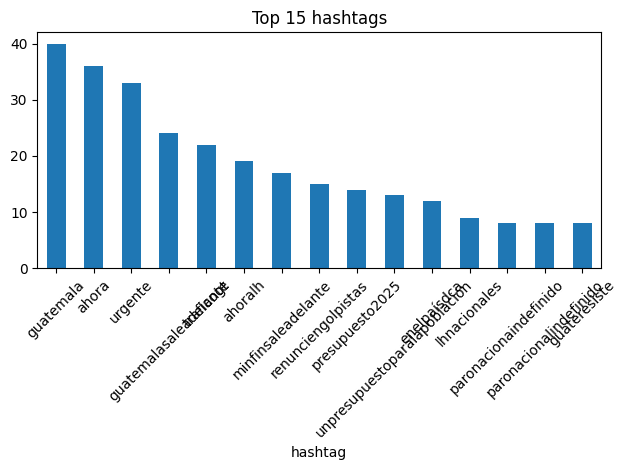

<Figure size 640x480 with 0 Axes>

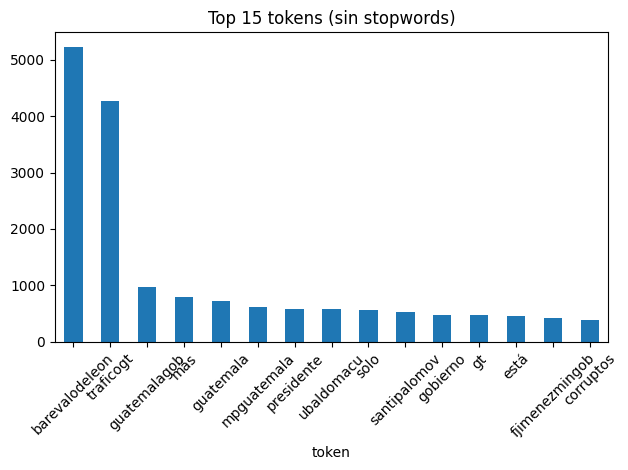

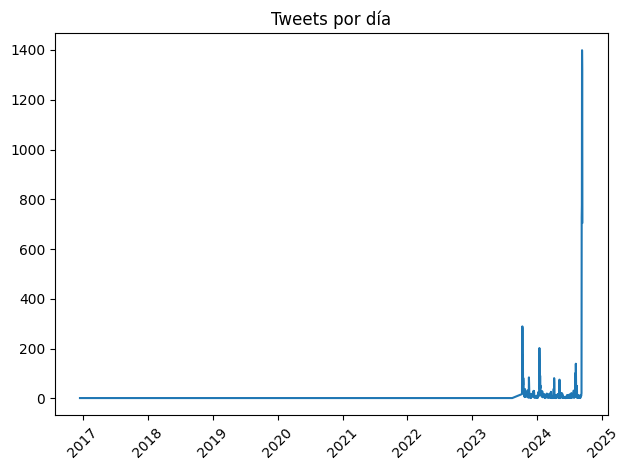

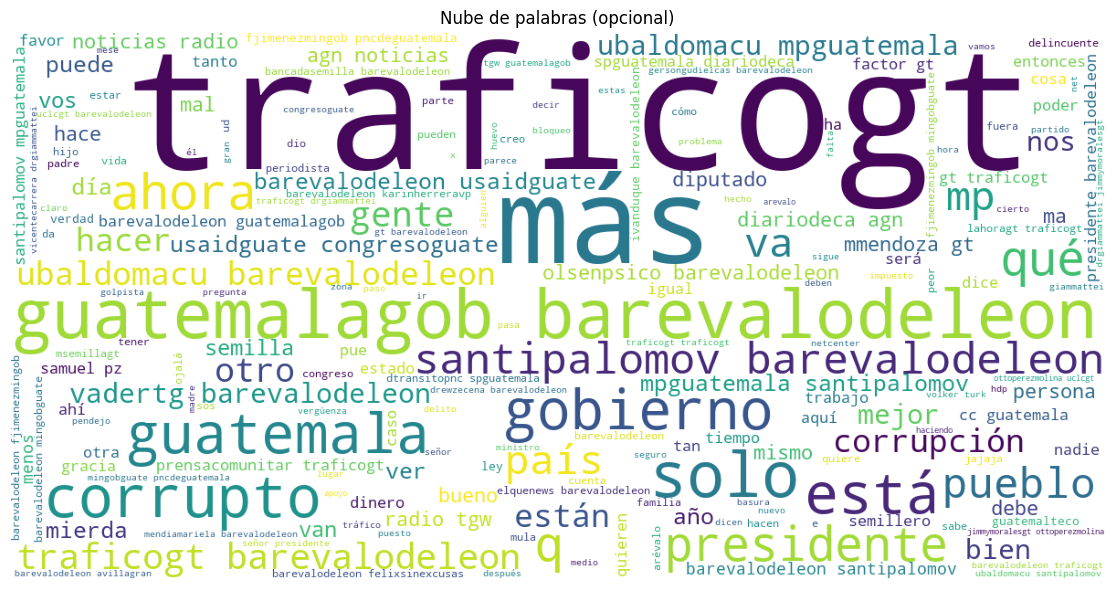

=== RESUMEN EDA (4.1) ===
Tweets totales: 10,539
Usuarios únicos (emitentes): 4,291
Menciones totales: 28,037 | Usuarios distintos mencionados: 1,856
Tweets que son replies: 8,552
Tweets que son retweets: 0

Top 10 hashtags:
  #guatemala: 40
  #ahora: 36
  #urgente: 33
  #guatemalasaleadelante: 24
  #traficogt: 22
  #ahoralh: 19
  #minfinsaleadelante: 17
  #renunciengolpistas: 15
  #presupuesto2025: 14
  #unpresupuestoparalapoblación: 13

Top 10 usuarios por # de tweets:
  @traficogt: 781
  @batallonjalapa: 134
  @mildred_gaitan: 105
  @lahoragt: 74
  @chofito63569841: 49
  @angeln8: 46
  @prensacomunitar: 45
  @papaabumario: 43
  @elrevoltijogt: 40
  @hellboy17oc: 39

Top 10 usuarios más mencionados:
  @barevalodeleon: 5168
  @traficogt: 4232
  @guatemalagob: 961
  @mpguatemala: 602
  @ubaldomacu: 572
  @santipalomov: 518
  @fjimenezmingob: 411
  @drgiammattei: 318
  @mingobguate: 309
  @congresoguate: 309

Archivos generados en: C:\Users\garci\OneDrive\Documentos\Tercer semestre U\IA

In [5]:
# === Celda A — Inciso 4.1: Análisis Exploratorio (EDA) ===
# - Usa df_proc de la celda anterior; si no existe, intenta reconstruirlo rápido desde los txt.
# - Calcula: cuentas básicas, top hashtags, top tokens, top usuarios, timeline, interacciones.
# - Genera gráficos (matplotlib) y guarda CSV/PNGs para documentación.
#
# Al final imprime: "RESUMEN EDA (4.1)"

import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# ---------- Helpers de carga mínima (por si abres el notebook desde cero) ----------
def _ensure_df_proc():
    global df_proc
    if "df_proc" in globals() and isinstance(df_proc, pd.DataFrame) and not df_proc.empty:
        return df_proc

    # Fallback 1: si dejaste la muestra limpia
    if Path("tweets_clean_sample.csv").exists():
        tmp = pd.read_csv("tweets_clean_sample.csv")
        # columnas listas
        for col in ["mentions","hashtags","tokens","tokens_nostop"]:
            if col in tmp.columns:
                tmp[col] = tmp[col].apply(lambda x: [] if pd.isna(x) else eval(x) if isinstance(x,str) else [])
        # normaliza fechas
        if "date" in tmp.columns:
            tmp["date"] = pd.to_datetime(tmp["date"], errors="coerce")
        dfp = tmp
        return dfp

    # Fallback 2 (reconstrucción mínima): vuelve a leer JSONL UTF-16 y limpia básico
    import json
    def _read_bytes_auto(path: Path) -> str:
        data = path.read_bytes()
        if data.count(0)/max(1,len(data)) > 0.01:
            for enc in ["utf-16","utf-16-le","utf-16-be","utf-8","latin-1"]:
                try:
                    s = data.decode(enc)
                    if s.count("\x00") < 5: return s
                except: pass
            return data.decode("utf-16", errors="ignore")
        return data.decode("utf-8", errors="ignore")
    def _json_maybe_twice(s):
        try:
            o = json.loads(s)
            if isinstance(o,str) and o.strip() and o.strip()[0] in "{[":
                try: return json.loads(o)
                except: return o
            return o
        except: return None

    rows=[]
    for p in ["traficogt.txt","/mnt/data/traficogt.txt","tioberny.txt","/mnt/data/tioberny.txt"]:
        p=Path(p)
        if not p.exists(): continue
        raw=_read_bytes_auto(p)
        for line in raw.splitlines():
            s=line.strip().rstrip(",")
            if not s: continue
            obj=_json_maybe_twice(s)
            if not isinstance(obj,dict): continue
            r=obj; u=r.get("user") if isinstance(r.get("user"),dict) else {}
            def _norm(u):
                if not u: return None
                u=str(u).strip()
                if u.startswith("@"): u=u[1:]
                return u.lower()
            # mentions
            m=[]
            if "mentionedUsers" in r and isinstance(r["mentionedUsers"],list):
                for it in r["mentionedUsers"]:
                    if isinstance(it,dict):
                        un=it.get("username") or it.get("screen_name") or it.get("name")
                        if un: m.append(_norm(un))
            # hashtags
            hs=[]
            if isinstance(r.get("hashtags"),list):
                for h in r["hashtags"]:
                    if isinstance(h,str): hs.append(h.lstrip("#").lower())
                    elif isinstance(h,dict):
                        t=h.get("text") or h.get("tag")
                        if t: hs.append(str(t).lstrip("#").lower())
            rows.append({
                "source_file": p.name,
                "tweet_id": r.get("id") or r.get("id_str"),
                "date": pd.to_datetime(r.get("date") or r.get("created_at"), errors="coerce"),
                "lang": r.get("lang"),
                "username": _norm((u.get("username") or u.get("screen_name") or u.get("name")) if u else None),
                "text": (r.get("rawContent") or r.get("full_text") or r.get("text")),
                "mentions": m,
                "hashtags": hs,
                "is_retweet": bool(r.get("retweetedTweet") or r.get("retweeted_status")),
                "reply_to_user": _norm((r.get("inReplyToUser") or {}).get("username") if isinstance(r.get("inReplyToUser"),dict) else r.get("in_reply_to_screen_name")),
            })
    dfp=pd.DataFrame(rows)
    if dfp.empty:
        raise RuntimeError("No pude reconstruir df_proc. Vuelve a ejecutar la celda 3 (preprocesamiento).")
    # limpieza mínima de texto para tokens
    def _fix(s):
        if isinstance(s,str) and ("Ã" in s or "Â" in s): 
            try: return s.encode("latin1","ignore").decode("utf-8","ignore")
            except: return s
        return s
    dfp["text"]=dfp["text"].apply(_fix)
    import re
    URL_RE=re.compile(r"https?://\S+|www\.\S+", re.I)
    KEEP=re.compile(r"[^a-záéíóúüñ\s]")
    def _clean(s):
        if not isinstance(s,str): return ""
        s=s.lower()
        s=URL_RE.sub(" ", s)
        s=s.replace("@"," ").replace("#"," ")
        s=KEEP.sub(" ", s)
        s=re.sub(r"\s+"," ",s).strip()
        return s
    dfp["text_clean"]=dfp["text"].apply(_clean)
    STOP=set("a al las los de del en la el y o que con por para un una uno unos unas se es no si como pero sobre ya muy sin más menos mi tu su sus lo me te le les es son ser fue fueron soy somos estoy están estaba están hasta hay".split())
    dfp["tokens"]=dfp["text_clean"].str.split()
    dfp["tokens_nostop"]=dfp["tokens"].apply(lambda ts: [t for t in ts if t not in STOP])
    return dfp

df_eda = _ensure_df_proc().copy()

# ---------- Métricas básicas ----------
n_tweets = len(df_eda)
n_users = int(df_eda["username"].dropna().nunique()) if "username" in df_eda else 0
n_mentions_total = int(sum(len(x or []) for x in df_eda["mentions"]))
unique_mentioned = set()
for xs in df_eda["mentions"]:
    unique_mentioned.update(xs or [])
n_users_mentioned = len(unique_mentioned)
n_replies = int(df_eda["reply_to_user"].notna().sum()) if "reply_to_user" in df_eda else 0
n_retweets = int(df_eda["is_retweet"].fillna(False).sum()) if "is_retweet" in df_eda else 0

# ---------- Top hashtags ----------
ht_counter = Counter(h for xs in df_eda["hashtags"] for h in (xs or []))
df_top_ht = pd.DataFrame(ht_counter.most_common(30), columns=["hashtag","count"])

# ---------- Top tokens (sin stopwords) ----------
tok_counter = Counter(t for xs in (df_eda["tokens_nostop"] if "tokens_nostop" in df_eda else df_eda["tokens"]) for t in (xs or []))
df_top_tokens = pd.DataFrame(tok_counter.most_common(30), columns=["token","count"])

# ---------- Usuarios más activos / más mencionados ----------
df_active_users = (df_eda.dropna(subset=["username"])
                   .groupby("username", as_index=False)
                   .agg(tweets=("tweet_id","count")))
# más mencionados
mentioned_counter = Counter()
for _, row in df_eda.iterrows():
    src = row.get("username")
    for dst in row.get("mentions") or []:
        mentioned_counter[dst] += 1
df_most_mentioned = pd.DataFrame(mentioned_counter.most_common(30), columns=["user","mentions_received"])

# ---------- Timeline (por día) ----------
if "date" in df_eda.columns:
    df_eda["date_only"] = df_eda["date"].dt.date
    ts_daily = (df_eda.dropna(subset=["date_only"])
                .groupby("date_only", as_index=False)
                .agg(tweets=("tweet_id","count"),
                     replies=("reply_to_user", lambda s: int(s.notna().sum())),
                     retweets=("is_retweet", lambda s: int(pd.Series(s).fillna(False).sum()))))
else:
    ts_daily = pd.DataFrame()

# ---------- Construcción de edges de interacción (para vistas/CSV) ----------
edges=[]
for _,row in df_eda.iterrows():
    src = row.get("username")
    if not src: continue
    # menciones
    for dst in (row.get("mentions") or []):
        if dst: edges.append((src,dst,"mention"))
    # reply
    dst = row.get("reply_to_user")
    if dst: edges.append((src,dst,"reply"))
    # retweet
    if row.get("is_retweet") and row.get("retweeted_user"):
        edges.append((src,row.get("retweeted_user"),"retweet"))

df_edges = pd.DataFrame(edges, columns=["src","dst","type"])

# ---------- Guardados ----------
out_dir = Path("eda_outputs")
out_dir.mkdir(exist_ok=True)
df_top_ht.to_csv(out_dir/"top_hashtags.csv", index=False)
df_top_tokens.to_csv(out_dir/"top_tokens.csv", index=False)
df_active_users.sort_values("tweets", ascending=False).head(100).to_csv(out_dir/"top_active_users.csv", index=False)
df_most_mentioned.head(100).to_csv(out_dir/"top_most_mentioned.csv", index=False)
df_edges.to_csv(out_dir/"edges_mentions_replies_retweets.csv", index=False)
ts_daily.to_csv(out_dir/"timeline_daily.csv", index=False)

# ---------- Gráficas rápidas ----------
plt.figure()
df_top_ht.head(15).plot(kind="bar", x="hashtag", y="count", legend=False, rot=45)
plt.title("Top 15 hashtags")
plt.tight_layout()
plt.savefig(out_dir/"top_hashtags.png")
plt.show()

plt.figure()
df_top_tokens.head(15).plot(kind="bar", x="token", y="count", legend=False, rot=45)
plt.title("Top 15 tokens (sin stopwords)")
plt.tight_layout()
plt.savefig(out_dir/"top_tokens.png")
plt.show()

if not ts_daily.empty:
    plt.figure()
    plt.plot(ts_daily["date_only"], ts_daily["tweets"])
    plt.title("Tweets por día")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(out_dir/"timeline_tweets.png")
    plt.show()

# Word cloud opcional si tienes instalado wordcloud
try:
    from wordcloud import WordCloud
    text_wc = " ".join(t for xs in df_eda.get("tokens_nostop", df_eda["tokens"]) for t in (xs or []))
    wc = WordCloud(width=1200, height=600, background_color="white").generate(text_wc)
    plt.figure(figsize=(12,6))
    plt.imshow(wc)
    plt.axis("off")
    plt.title("Nube de palabras (opcional)")
    plt.tight_layout()
    plt.savefig(out_dir/"wordcloud.png")
    plt.show()
except Exception as e:
    print("Nube de palabras no generada (falta 'wordcloud' o no hay tokens). Si quieres, instala 'wordcloud'.")

# ---------- Impresión del resumen ----------
print("=== RESUMEN EDA (4.1) ===")
print(f"Tweets totales: {n_tweets:,}")
print(f"Usuarios únicos (emitentes): {n_users:,}")
print(f"Menciones totales: {n_mentions_total:,} | Usuarios distintos mencionados: {n_users_mentioned:,}")
print(f"Tweets que son replies: {n_replies:,}")
print(f"Tweets que son retweets: {n_retweets:,}")
if not df_top_ht.empty:
    print("\nTop 10 hashtags:")
    for h,c in df_top_ht.head(10).itertuples(index=False):
        print(f"  #{h}: {c}")
if not df_active_users.empty:
    print("\nTop 10 usuarios por # de tweets:")
    for u,c in df_active_users.sort_values("tweets", ascending=False).head(10).itertuples(index=False):
        print(f"  @{u}: {c}")
if not df_most_mentioned.empty:
    print("\nTop 10 usuarios más mencionados:")
    for u,c in df_most_mentioned.head(10).itertuples(index=False):
        print(f"  @{u}: {c}")

print("\nArchivos generados en:", str(out_dir.resolve()))
print(" - top_hashtags.csv / .png")
print(" - top_tokens.csv / .png")
print(" - top_active_users.csv")
print(" - top_most_mentioned.csv")
print(" - edges_mentions_replies_retweets.csv")
print(" - timeline_daily.csv", "(y timeline_tweets.png si hay fechas)")


## **Inciso 4b**

In [6]:
# === Celda B — Inciso 4.2: Preguntas interesantes y resultados calculados ===
# Imprime 3 preguntas sugeridas y los datos que permiten responderlas.
# Al final: "PREGUNTAS Y RESPUESTAS (4.2) – RESULTADOS"
import pandas as pd
from collections import Counter

def _ensure_df_eda_again():
    if "df_eda" in globals():
        return df_eda
    elif "df_proc" in globals():
        return df_proc
    else:
        raise RuntimeError("Ejecuta primero la Celda A.")

D = _ensure_df_eda_again()

# 1) ¿Qué usuarios son más mencionados (potenciales hubs de atención)?
mentioned_counter = Counter()
for xs in D["mentions"]:
    if not isinstance(xs, list): 
        continue
    for m in xs:
        if m: mentioned_counter[m] += 1
df_q1 = pd.DataFrame(mentioned_counter.most_common(20), columns=["usuario","menciones_recibidas"])

# 2) ¿Quiénes son los usuarios más activos (más tweets emitidos) y qué % de sus tweets son replies?
df_q2 = (D.dropna(subset=["username"])
         .groupby("username", as_index=False)
         .agg(tweets=("tweet_id","count"),
              replies=("reply_to_user", lambda s: int(s.notna().sum()))))
df_q2["pct_reply"] = (df_q2["replies"] / df_q2["tweets"] * 100).round(1)
df_q2 = df_q2.sort_values(["tweets","pct_reply"], ascending=[False, False]).head(20)

# 3) ¿Cuáles son los hashtags más usados y su presencia relativa?
ht_counter = Counter(h for xs in D["hashtags"] for h in (xs or []))
total_ht = sum(ht_counter.values()) or 1
df_q3 = (pd.DataFrame(ht_counter.most_common(20), columns=["hashtag","freq"])
           .assign(pct=lambda x: (x["freq"]/total_ht*100).round(2)))

print("=== PREGUNTAS Y RESPUESTAS (4.2) – RESULTADOS ===")
print("\nP1) Usuarios más mencionados (Top 10):")
print(df_q1.head(10).to_string(index=False))

print("\nP2) Usuarios más activos y % de replies (Top 10):")
print(df_q2.head(10).to_string(index=False))

print("\nP3) Hashtags más usados y participación (Top 10):")
print(df_q3.head(10).to_string(index=False))

# Guardados
out_dir = Path("eda_outputs")
out_dir.mkdir(exist_ok=True)
df_q1.to_csv(out_dir/"q1_mas_mencionados.csv", index=False)
df_q2.to_csv(out_dir/"q2_mas_activos_y_pct_reply.csv", index=False)
df_q3.to_csv(out_dir/"q3_hashtags_top_con_pct.csv", index=False)
print(f"\nArchivos: {str((out_dir/'q1_mas_mencionados.csv').resolve())}, "
      f"{str((out_dir/'q2_mas_activos_y_pct_reply.csv').resolve())}, "
      f"{str((out_dir/'q3_hashtags_top_con_pct.csv').resolve())}")


=== PREGUNTAS Y RESPUESTAS (4.2) – RESULTADOS ===

P1) Usuarios más mencionados (Top 10):
       usuario  menciones_recibidas
barevalodeleon                 5168
     traficogt                 4232
  guatemalagob                  961
   mpguatemala                  602
    ubaldomacu                  572
  santipalomov                  518
fjimenezmingob                  411
  drgiammattei                  318
   mingobguate                  309
 congresoguate                  309

P2) Usuarios más activos y % de replies (Top 10):
       username  tweets  replies  pct_reply
      traficogt     781       39        5.0
 batallonjalapa     134      134      100.0
 mildred_gaitan     105      105      100.0
       lahoragt      74        2        2.7
chofito63569841      49       49      100.0
        angeln8      46       43       93.5
prensacomunitar      45        5       11.1
   papaabumario      43       43      100.0
  elrevoltijogt      40        7       17.5
    hellboy17oc      39